NomicEmbeddings

add database to google api

utilities:   
- patients DB creator

steps:
- Create Agents
- Define tools
- Create graph
- Define Agent Nodes
- Define Tool Node
- Define Edge Logic
- Define the Graph
- show the graph
- Invoke
  
- Human in the loop
- Maximum number of steps
- Helper Utilities

# LLM Agents for Clinical Trial Management

In this notebook, we develop an agent-based system to automate the management and analysis of clinical trial data, ensuring compliance with regulatory standards, and providing comprehensive reports for stakeholders. This pipeline also incorporate human-in-the-loop (HITL) and memory mechanisms to enhance functionality and accuracy.

## Steps and Plan

1. Define the Problem:

Objective: Automate clinical trial data management, analysis, compliance checks, and reporting.

Key Components: Data collection, data analysis, compliance verification, reporting, and human-in-the-loop interventions.

2. Design the Architecture:
**Agents:**
Data Collection Agent: Gathers patient data, trial results, and other relevant information.

Data Analysis Agent: Analyzes the collected data to generate reports on trial outcomes.

Compliance Agent: Ensures all data and processes adhere to regulatory standards.

Reporting Agent: Compiles and presents the analysis findings in comprehensive reports.

Human-in-the-Loop: Integrate a review phase where human experts validate data analysis and compliance checks before final reporting.

Memory: Utilize LangGraph’s memory capabilities to track the progress and history of each trial.

The Clinical Trial Matching Agent is designed to match patients wit	h suitable clinical trials based on their medical history, symptoms, and ongoing treatments. This application helps patients find relevant clinical trials they may be eligible for, improving their chances of accessing new treatments and contributing to medical research.


1. Database Setup
- SQLite Database: Create two databases:
- Patients DB: Stores patient medical history, previous trials, and other relevant data.
- Clinical Trials DB: Contains information about ongoing and upcoming clinical trials, including eligibility criteria.
2. Agents and Tools
- Patient Data Ingestion Agent: Retrieves patient data from the SQLite database or prompts the user to provide missing data.
- Data Validation and Collection Loop: Ensures all required fields are collected using persistence.
- Policy Compliance Agent: Cross-checks patient data with institutional policies.
- Trial Vectorization Agent: Extracts and vectorizes recruiting trials for efficient search.
- Trial Matching Agent: Forms prompts from patient data to search the vector database for potential trial matches.
- Human-in-the-Loop (HIL) Agent: Presents top trial matches to the user for selection.
- Persistence Mechanism: Allows the application to save and resume states, especially useful for collecting patient data and searching trials.

In [1]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Clinical Trial Management"

In [2]:
# import os

# from dotenv import load_dotenv, find_dotenv
# _ = load_dotenv(find_dotenv()) # read local .env file

import warnings
warnings.filterwarnings("ignore")

import pprint
# A function for printing nicely
def nprint(text, indent=2):
    pp = pprint.PrettyPrinter(indent=indent)
    pp.pprint(text)

In [3]:
import pandas as pd
from datetime import datetime, timedelta

# Generate the sample data again for display
columns = ["patient_id", "name", "age", "medical_history", "previous_trials", "trial_status", "last_trial_dates"]
data = []

import random

# Given names and surnames
names = ["John", "Jane", "Alice", "Michael", "Emily", "Daniel", "Sophia", "James", "Emma", "Oliver"]
surnames = ["Doe", "Smith", "Johnson", "Brown", "Davis", "Garcia", "Martinez", "Anderson", "Thomas", "Wilson"]

# Generate all possible unique combinations of names and surnames
combinations = [(name, surname) for name in names for surname in surnames]

# Shuffle the combinations to ensure randomness
random.shuffle(combinations)

# Select the first 100 unique combinations
unique_names = combinations[:100]

# Generate the full names
full_names = [f"{name} {surname}" for name, surname in unique_names]

# Display the first few full names for verification
print(full_names[:10])

# Optionally, you can also display all 100 unique full names
# print(len(full_names))
# unique entries of list full_names
print(len(set(full_names)))

medical_conditions = ["Hypertension", "Diabetes", "Asthma", "Heart Disease", "Arthritis",
                      "Chronic Pain", "Anxiety", "Depression", "Cancer", "Obesity"]
trial_statuses = ["Completed", "Ongoing", "Withdrawn"]

def random_date(start, end):
    return start + timedelta(days=random.randint(0, int((end - start).days)))

# start_date must be 2 years before now
start_date = datetime.now() - timedelta(days=365 * 2)
# start_date = datetime(2020, 1, 1)

# end_date must be a month before now
end_date = datetime.now() - timedelta(days=10)
# end_date = datetime(2023, 1, 1)

for i in range(1, 101):
    name = random.choice(full_names)
    age = random.randint(20, 80)
    medical_history = random.choice(medical_conditions)
    
    if random.choice([True, False]):
        previous_trials = f"Trial {random.randint(1, 20)}"
        trial_status = random.choice(trial_statuses)
        last_trial_dates = random_date(start_date, end_date).strftime('%Y-%m-%d')
    else:
        previous_trials = ""
        trial_status = ""
        last_trial_dates = ""

    data.append((i, name, age, medical_history, previous_trials, trial_status, last_trial_dates))

df = pd.DataFrame(data, columns=columns)
# save df to csv
df.to_csv("patients.csv", index=False)
df.head(20)

['Emma Smith', 'Michael Smith', 'Jane Smith', 'Sophia Brown', 'Daniel Martinez', 'Oliver Doe', 'John Anderson', 'John Smith', 'Sophia Doe', 'Emily Davis']
100


,patient_id,name,age,medical_history,previous_trials,trial_status,last_trial_dates
0,1,Michael Davis,42,Heart Disease,Trial 13,Withdrawn,2024-05-24
1,2,John Davis,40,Depression,Trial 2,Completed,2024-01-13
2,3,James Davis,67,Anxiety,Trial 7,Completed,2022-07-28
3,4,Emma Anderson,44,Chronic Pain,Trial 13,Completed,2023-12-15
4,5,Michael Anderson,49,Arthritis,Trial 2,Ongoing,2022-09-25
5,6,Alice Brown,46,Chronic Pain,Trial 3,Withdrawn,2023-05-10
6,7,Emily Doe,25,Anxiety,Trial 14,Ongoing,2024-03-19
7,8,Jane Johnson,44,Chronic Pain,,,
8,9,Jane Smith,61,Asthma,Trial 4,Withdrawn,2022-07-27
9,10,Jane Garcia,70,Cancer,,,


In [4]:
import os
# import shutil
import sqlite3

import pandas as pd

overwrite = True

database_file = 'patients_database.db'
df = pd.read_csv('patients.csv')
if overwrite or not os.path.exists(database_file):
    if os.path.exists(database_file):
        os.remove(database_file)
    conn = sqlite3.connect(database_file)
    cursor = conn.cursor()
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS patients (
        patient_id INTEGER PRIMARY KEY,
        name TEXT,
        age INTEGER,
        medical_history TEXT,
        previous_trials TEXT,
        trial_status TEXT,
        last_trial_dates TEXT
    )
    ''')

    # Insert DataFrame into SQLite table
    df.to_sql('patients', conn, if_exists='append', index=False)

    # Commit and close the connection
    conn.commit()
else:
    conn = sqlite3.connect(database_file)
    cursor = conn.cursor()

query = 'SELECT * FROM patients'

# Execute the query and fetch all results
cursor.execute(query)
rows = cursor.fetchall()

# Optionally, you can get the column names
column_names = [description[0] for description in cursor.description]

# Convert the results to a Pandas DataFrame for better readability
df = pd.DataFrame(rows, columns=column_names)
print(len(df))

# Display the DataFrame
conn.close()

db = database_file
df.head(10)

100


,patient_id,name,age,medical_history,previous_trials,trial_status,last_trial_dates
0,1,Michael Davis,42,Heart Disease,Trial 13,Withdrawn,2024-05-24
1,2,John Davis,40,Depression,Trial 2,Completed,2024-01-13
2,3,James Davis,67,Anxiety,Trial 7,Completed,2022-07-28
3,4,Emma Anderson,44,Chronic Pain,Trial 13,Completed,2023-12-15
4,5,Michael Anderson,49,Arthritis,Trial 2,Ongoing,2022-09-25
5,6,Alice Brown,46,Chronic Pain,Trial 3,Withdrawn,2023-05-10
6,7,Emily Doe,25,Anxiety,Trial 14,Ongoing,2024-03-19
7,8,Jane Johnson,44,Chronic Pain,None,None,None
8,9,Jane Smith,61,Asthma,Trial 4,Withdrawn,2022-07-27
9,10,Jane Garcia,70,Cancer,None,None,None


## Tools

In [5]:
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

def get_patient_data(patient_id: int) -> dict:
    """Fetch all fields for the patient based on the given patient_id as an integer.

    Returns:
        A dictionary containing the patient's medical history.        
    """

    # config = ensure_config()  # Fetch from the context
    # configuration = config.get("configurable", {})
    # patient_id = configuration.get("patient_id", None)

    # if not patient_id:
    #     raise ValueError("No patient ID given.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()    
    query = 'SELECT * FROM patients WHERE patient_id=?'
    cursor.execute(query, (patient_id,))
    patient_data = cursor.fetchone()
    # rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    conn.close()
    if patient_data is None:
        return None
    else:    
        results = dict(zip(column_names, patient_data))    
    return results


def add_patient_data(patient_data: dict):    
    """Adds a new patient to the SQLite database."""
    
    name = patient_data['name']
    age = patient_data['age']
    medical_history = patient_data['medical_history']
    previous_trials = patient_data['previous_trials']
    trial_status = patient_data['trial_status']
    last_trial_dates = patient_data['last_trial_dates']

    conn = sqlite3.connect(db)
    cursor = conn.cursor()
    
    # Insert the new patient data into the database
    cursor.execute('''
    INSERT INTO patients (name, age, medical_history, previous_trials, trial_status, last_trial_dates)
    VALUES (?, ?, ?, ?, ?, ?)
    ''', (name, age, medical_history, previous_trials, trial_status, last_trial_dates))
    
    conn.commit()
    conn.close()


In [6]:
sample_patient_id = 1
patient_data = get_patient_data('1')
print(patient_data)

{'patient_id': 1, 'name': 'Michael Davis', 'age': 42, 'medical_history': 'Heart Disease', 'previous_trials': 'Trial 13', 'trial_status': 'Withdrawn', 'last_trial_dates': '2024-05-24'}


Creating vectorstore

local embedding via NomicEmbeddings

In [21]:
# from gpt4all import Embed4All
# model_name = 'nomic-embed-text-v1.5.f16.gguf'
# text = 'The quick brown fox jumps over the lazy dog'
# # you can change it to cuda if you have available GPU
# embedder = Embed4All(model_name, device='cpu')
# output = embedder.embed(text)
# print(len(output))

import re

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_core.documents import Document


urls = [
#     # "https://lilianweng.github.io/posts/2023-06-23-agent/",
    #  "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    # "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
    "https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md"

]

markdown_path = "../../source_data/instut_trials_policy.md"
# markdown_path = "../../temp/swiss_faq.md"

with open(markdown_path, "r") as f:
    policy_text = f.read()

# loader = UnstructuredMarkdownLoader(markdown_path)
# docs = loader.load()

doc_splits = [
    Document(page_content= txt, metadata={"source": markdown_path}) for txt in re.split(r"(?=\n###)", policy_text)
    ]

# the title of markdown is not required in the split
doc_splits = doc_splits[1:]    

# docs = [WebBaseLoader(url).load() for url in urls]
# docs_list = [item for sublist in docs for item in sublist]

# text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    # chunk_size=250, chunk_overlap=0
# )
# doc_splits = text_splitter.split_documents(docs_list)
print(len(doc_splits))
doc_splits

# Add to vectorDB
# load the existing vectorstore from "rag-chroma"


if vstore_created:
    vectorstore.delete_collection()

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=NomicEmbeddings(model="nomic-embed-text-v1.5",
                              inference_mode='local'),
)
vstore_created = True

retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
question = "policy about patient's past trials"
docs_retrieved = retriever.get_relevant_documents(question)
print(len(docs_retrieved))
doc_txt = docs_retrieved[0].page_content
print(doc_txt)

7
2

#### 3. **Previous Trial Participation**
   - **Trial Washout Period**: Patients must not have participated in any other clinical trial within the last 30 days.
   - **Trial Frequency**: Patients should not have participated in more than two clinical trials in the past year to prevent overexposure to experimental treatments.
   - **Active Trials**: Patients currently enrolled in another active trial are not eligible until they have completed or withdrawn from the ongoing trial.
   - **Recent Trial Completion**: Patients must have completed their last trial at least 30 days prior to enrolling in a new trial to allow for proper assessment of any delayed adverse effects.
   - **Trial Outcomes**:
     - Patients who were withdrawn from previous trials due to adverse effects are not eligible.
     - Patients who have completed a trial must have a documented recovery period before participating in a new trial.



# State

In [62]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage, ToolMessage

# from typing import TypedDict

class AgentState(TypedDict):
    patient_prompt: str
    patient_id: int
    # trials: str
    # draft: str
    # critique: str
    patient_data: dict
    revision_number: int
    max_revisions: int

## Agent

==================== Using ESSAY

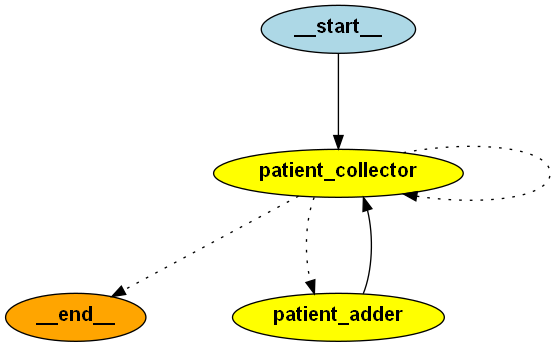

In [43]:
from langgraph.checkpoint.sqlite import SqliteSaver

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost

memory = SqliteSaver.from_conn_string(":memory:")


# ------- Agents:
from langchain_core.pydantic_v1 import BaseModel
class Patient_ID(BaseModel):
    patient_id: int
    # no_id: bool

model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)  #reduce inference cost
patient_data_prompt = """You are a helpful assistance in extrcting patient's medical history.
Based on the following request identify and return the patient's ID number.
"""
# If you cannot find patient ID in the request text then return 10000 as response.

def patient_collector_node(state: AgentState):
    response = model.with_structured_output(Patient_ID).invoke([
        SystemMessage(content=patient_data_prompt),
        HumanMessage(content=state['patient_prompt'])
    ])
    patient_id = response.patient_id
    print(response)
    print(f"Patient ID: {patient_id}")
    result = get_patient_data(patient_id)
    
    return {
        "patient_data": result,
        "revision_number": state.get("revision_number", 1) + 1
        }

# Define the agent state structure
class NewPatientData(TypedDict):
    name: str
    age: int
    medical_history: str
    previous_trials: str
    trial_status: str
    last_trial_dates: str


# def patient_adder_node(state: AgentState):
#     # x= input("Enter patient data: ")
#     # print(x)
#     add_patient_data(
#         {"name": "John Doe", 
#         "age": 45, 
#         "medical_history": "Hypertension", 
#         "previous_trials": "Trial 15", 
#         "trial_status": "Completed", 
#         "last_trial_dates": "2021-06-14"}
#         )
#     print('patient added')    

def should_continue(state: AgentState):
    end = False
    if state.get("patient_data"):
        print('patient data found')
        print(state.get("patient_data"))
        # end = True
    else:
        print('patient data not found')
        end = True
        
    if state["revision_number"] > state["max_revisions"]:
        print('max revision reached')
        # print(state.get("patient_data", 1))
        end = True
    
    if end:
        return END
    return "patient_collector"


# ==== define graph ====
from langgraph.graph import StateGraph, END

builder = StateGraph(AgentState)
builder.set_entry_point("patient_collector")

builder.add_node("patient_collector", patient_collector_node)
# builder.add_node("patient_adder", patient_adder_node)

# builder.add_edge("patient_adder", "patient_collector")

builder.add_conditional_edges(
    "patient_collector", 
    should_continue, 
    {END: END,
    "patient_collector": "patient_collector"
    ,"patient_adder": "patient_adder"
    }
)



graph = builder.compile(
    checkpointer=memory
    , interrupt_before=["patient_adder"]
)

from IPython.display import Image

Image(graph.get_graph().draw_png())



In [44]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'patient_prompt': "Is patient 102 eligible for any medical trial?",
    # 'patient_prompt': "Is patient Max eligible for any medical trial?",
    "max_revisions": 1,
    "revision_number": 1,
}, thread):
    print(s)

patient_id=102
Patient ID: 102
patient data not found --> patient_adder_node
{'patient_collector': {'patient_data': None, 'revision_number': 2}}


In [47]:
# s.get("patient_collector")
# graph.get_state(thread).next
# graph.get_state_history(thread)
current_state = graph.get_state(thread)
current_state.values["patient_prompt"] = 'Is patient 100 eligible for any medical trial?'
graph.update_state(thread, current_state.values)
# s
# a=10000
# type(a)

patient data not found --> patient_adder_node


{'configurable': {'thread_id': '1',
  'thread_ts': '1ef2f4b1-a2ee-6432-8002-173519ee5347'}}

In [55]:
states = []
for state in graph.get_state_history(thread):
    print(state)
    print('--')
    states.append(state)

StateSnapshot(values={'patient_prompt': 'Is patient 100 eligible for any medical trial?', 'patient_data': {'patient_id': 100, 'name': 'James Smith', 'age': 61, 'medical_history': 'Anxiety', 'previous_trials': 'Trial 5', 'trial_status': 'Withdrawn', 'last_trial_dates': '2022-08-11'}, 'revision_number': 2, 'max_revisions': 1}, next=(), config={'configurable': {'thread_id': '1', 'thread_ts': '1ef2f4f8-39c8-6a94-8002-3e4ec9483244'}}, metadata={'source': 'loop', 'step': 2, 'writes': {'patient_collector': {'patient_data': {'patient_id': 100, 'name': 'James Smith', 'age': 61, 'medical_history': 'Anxiety', 'previous_trials': 'Trial 5', 'trial_status': 'Withdrawn', 'last_trial_dates': '2022-08-11'}, 'revision_number': 2}}}, created_at='2024-06-20T21:53:22.877096+00:00', parent_config={'configurable': {'thread_id': '1', 'thread_ts': '1ef2f4f7-19d3-601f-8001-87ae15683d5d'}})
--
StateSnapshot(values={'patient_prompt': 'Is patient 100 eligible for any medical trial?', 'revision_number': 1, 'max_rev

In [53]:
state = states[2]
state.values["patient_prompt"] = 'Is patient 100 eligible for any medical trial?'
branch_state = graph.update_state(state.config, state.values)
branch_state

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef2f4f7-19d3-601f-8001-87ae15683d5d'}}

In [54]:
for event in graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)

patient_id=100
Patient ID: 100
patient data found
{'patient_id': 100, 'name': 'James Smith', 'age': 61, 'medical_history': 'Anxiety', 'previous_trials': 'Trial 5', 'trial_status': 'Withdrawn', 'last_trial_dates': '2022-08-11'}
max revision reached
{'patient_data': {'patient_id': 100, 'name': 'James Smith', 'age': 61, 'medical_history': 'Anxiety', 'previous_trials': 'Trial 5', 'trial_status': 'Withdrawn', 'last_trial_dates': '2022-08-11'}, 'revision_number': 2}


## =========== GPT way ==============

In [3]:
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI

# Define the function that calls the model
def call_model(state):
    # In this simple example, we just pass the patient_id to the tool and get the patient data
    patient_id = state["patient_id"]
    patient_data = retrieve_patient_data_tool(patient_id)
    return {"patient_data": patient_data}

# Define the function that determines whether to continue or not
def should_continue(state):
    if state.get("patient_data"):
        return "end"
    return "continue"

# Initialize the state graph
workflow = StateGraph()

# Add nodes
workflow.add_node("retrieve_patient_data", call_model)

# Set entry point
workflow.set_entry_point("retrieve_patient_data")

# Define conditional edges
workflow.add_conditional_edges(
    "retrieve_patient_data",
    should_continue,
    {"continue": "retrieve_patient_data", "end": END}
)

# Compile the workflow
app = workflow.compile()

# Example invocation
initial_state = {"patient_id": 1}
app.invoke(initial_state)


TypeError: StateGraph.__init__() missing 1 required positional argument: 'state_schema'

## Dummy tests

In [12]:
assert 1==2

     type                  name              tbl_name  rootpage  \
0   table        aircrafts_data        aircrafts_data         2   
1   table         airports_data         airports_data         3   
2   table       boarding_passes       boarding_passes         4   
3   table              bookings              bookings         5   
4   table               flights               flights         6   
5   table                 seats                 seats         7   
6   table        ticket_flights        ticket_flights         8   
7   table               tickets               tickets         9   
8   table           car_rentals           car_rentals     21958   
9   table                hotels                hotels     21961   
10  table  trip_recommendations  trip_recommendations     21962   

                                                  sql  
0   CREATE TABLE "aircrafts_data" (\n"aircraft_cod...  
1   CREATE TABLE "airports_data" (\n"airport_code"...  
2   CREATE TABLE "boarding_

In [ ]:

import os
import shutil
import sqlite3

import pandas as pd
import requests

db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
local_file = "travel2.sqlite"
# The backup lets us restart for each tutorial section
backup_file = "travel2.backup.sqlite"
overwrite = False
if overwrite or not os.path.exists(local_file):
    response = requests.get(db_url)
    response.raise_for_status()  # Ensure the request was successful
    with open(local_file, "wb") as f:
        f.write(response.content)
    # Backup - we will use this to "reset" our DB in each section
    shutil.copy(local_file, backup_file)
# Convert the flights to present time for our tutorial
# local_file = 
conn = sqlite3.connect(local_file)
cursor = conn.cursor()

query = 'SELECT * FROM sqlite_master'

# Execute the query and fetch all results
cursor.execute(query)
rows = cursor.fetchall()

# Optionally, you can get the column names
column_names = [description[0] for description in cursor.description]

# Convert the results to a Pandas DataFrame for better readability
df = pd.DataFrame(rows, columns=column_names)

# Display the DataFrame
print(df)

In [6]:
tdf

NameError: name 'tdf' is not defined